<h1 align="center" style="color:green;font-size: 3em;" >用Pytorch从头实现Transformer</h1>
 
<img src="https://theaisummer.com/static/6122618d7e1466853e88473ba375cdc7/40ffe/transformer.png">



## 1. 导入库

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

1.9.1+cpu


## 2.基本组件

## 创建词嵌入

- 这个 `Embedding` 类用于将词汇索引转换为相应的嵌入向量，以便输入到神经网络中。
- `nn.Embedding` 层通过查表的方式，将每个词汇的索引映射到一个固定维度的嵌入向量上。


In [2]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: 词汇表大小
            embed_dim: 嵌入维度
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        """
        Args:
            x: 输入向量，通常是一个包含词汇索引的张量（整数表示词汇在词汇表中的位置）
            out: 嵌入向量
        """
        out = self.embed(x)
        return out

## 位置嵌入

这个 PositionalEmbedding 模块通过对每个位置进行正弦和余弦编码，为每个输入序列的嵌入向量提供了位置信息，使模型能够感知序列中词汇的顺序。


In [3]:
class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_model_dim):
        """
        Args:
            max_seq_len: 输入序列的最大长度
            embed_model_dim: 嵌入的维度
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim

        # 生成位置嵌入矩阵
        # 为每个位置计算对应的正弦和余弦编码
        pe = torch.zeros(max_seq_len,self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                # i = 0,2,4,6 ...
                pe[pos, i] = np.sin(pos/(10000**(i/self.embed_dim)))
                if i+1 < self.embed_dim:
                    pe[pos, i+1] = np.cos(pos/(10000**(i/self.embed_dim)))
                    
        # 扩展维度以适应批量输入
        # 使用unsqueeze(0)在第一个维度上增加一个维度，使pe的形状变为(1, max_seq_len, embed_dim)。
        pe = pe.unsqueeze(0)
        
        # 将 pe 注册为 buffer，防止它在训练过程中被更新
        # 缓冲区的作用：在模型保存和加载时，缓冲区会一同保存，但不会作为模型参数参与训练。
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Args:
            x: 输入的词嵌入张量，形状通常为(batch_size, seq_len, embed_dim)
        Returns:
            x: 输出
        """
      
        # 使输入嵌入向量的值相对较大
        x = x * math.sqrt(self.embed_dim)
        # 获取输入序列的长度
        seq_len = x.size(1)
        # 提取对应长度的位置嵌入，将位置嵌入与词嵌入相加，融合位置信息
        x = x + torch.autograd.Variable(self.pe[:, :seq_len, :], requires_grad=False)
        return x
               


## 自注意力

这个 `MultiHeadAttention` 类实现了**多头注意力机制**（Multi-Head Attention），是 Transformer 中的一个重要组件。多头注意力机制允许模型通过多个注意力头（heads）从不同的子空间中关注不同的部分。

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: 嵌入向量的维度
            n_heads: 注意力头的数量
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim  # 512维嵌入向量
        self.n_heads = n_heads  # 8个注意力头
        self.single_head_dim = int(self.embed_dim / self.n_heads)  # 每个注意力头的维度 = 512 / 8 = 64

        # 定义线性变换矩阵，用于生成 Query, Key 和 Value 矩阵
        self.query_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
        self.key_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)

        # 输出线性层，作用是将多头注意力的输出拼接并变换回原始嵌入维度
        self.out = nn.Linear(self.n_heads * self.single_head_dim, self.embed_dim)


    def forward(self, key, query, value, mask=None):
        """
        Args:
           key: Key 向量
           query: Query 向量
           value: Value 向量
           mask: 用于屏蔽不需要计算注意力的部分
        Returns:
           output: 多头注意力机制的输出
        """
        batch_size = key.size(0)
        seq_length = key.size(1)
        seq_length_query = query.size(1)

        # 重塑 key, query 和 value 的维度，使其适应多头注意力的格式
        # key、query、value 的输入维度为 (batch_size, seq_length, embed_dim)，例如 (32, 10, 512) 表示 32 个序列，每个序列长度为 10，每个词的嵌入维度为 512。
        # 使用view()而不是reshape()的理由：view() 不会创建新张量，只是修改现有张量的元数据（假设内存布局是连续的），因此速度快，内存开销低。
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)  # (32, 10, 8, 64)
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim)

        # 线性变换得到 Q, K, V 矩阵
        k = self.key_matrix(key)  # (32, 10, 8, 64)
        q = self.query_matrix(query)  # (32, 10, 8, 64)
        v = self.value_matrix(value)  # (32, 10, 8, 64)

        # 交换维度，适应矩阵乘法的形状
        q = q.transpose(1, 2)  # (32, 8, 10, 64)
        k = k.transpose(1, 2)  # (32, 8, 10, 64)
        v = v.transpose(1, 2)  # (32, 8, 10, 64)

        # 计算注意力分数
        k_adjusted = k.transpose(-1, -2)  # 调整 Key 矩阵以便于与 Query 相乘 (32, 8, 64, 10)
        product = torch.matmul(q, k_adjusted)  # 矩阵乘法得到注意力分数 (32, 8, 10, 10)

        # 如果提供了 mask，则屏蔽某些位置的注意力分数
        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20"))

        # 对 Key 的维度进行缩放，缓解梯度消失问题
        product = product / math.sqrt(self.single_head_dim)  # 缩放因子 √64

        # 计算注意力权重
        scores = F.softmax(product, dim=-1)  # (32, 8, 10, 10)

        # 将注意力权重与 Value 相乘，得到加权后的输出
        scores = torch.matmul(scores, v)  # (32, 8, 10, 64)

        # 将多头的输出拼接起来
        concat = scores.transpose(1, 2).contiguous().view(batch_size, seq_length_query, self.single_head_dim * self.n_heads)  # (32, 10, 512)

        # 通过线性层输出
        output = self.out(concat)  # (32, 10, 512)

        return output


## 3.编码器

<img src="https://www.researchgate.net/profile/Ehsan-Amjadian/publication/352239001/figure/fig1/AS:1033334390013952@1623377525434/Detailed-view-of-a-transformer-encoder-block-It-first-passes-the-input-through-an.jpg" width=300 height=200>


`TransformerBlock` 是 Transformer 编码器的基本单元，它由多头注意力机制、残差连接、归一化层、前馈神经网络和 dropout 组成。

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(TransformerBlock, self).__init__()
        
        """
        Args:
           embed_dim: 嵌入向量的维度
           expansion_factor: 前馈网络的扩展因子，用于扩展中间层的维度
           n_heads: 注意力头的数量
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads)  # 多头注意力机制
        
        self.norm1 = nn.LayerNorm(embed_dim)  # 第一个归一化层（LayerNorm）
        self.norm2 = nn.LayerNorm(embed_dim)  # 第二个归一化层
        
        self.feed_forward = nn.Sequential(  # 前馈神经网络部分
                          nn.Linear(embed_dim, expansion_factor * embed_dim),  # 线性层，维度从 embed_dim 扩展到 expansion_factor * embed_dim
                          nn.ReLU(),  # 激活函数，引入非线性
                          nn.Linear(expansion_factor * embed_dim, embed_dim)  # 再次将维度缩小到原始的 embed_dim
        )

        self.dropout1 = nn.Dropout(0.2)  # 第一个 dropout，用于防止过拟合
        self.dropout2 = nn.Dropout(0.2)  # 第二个 dropout

    def forward(self, key, query, value):
        """
        Args:
           key: Key 向量
           query: Query 向量
           value: Value 向量
        
        Returns:
           norm2_out: 经过 Transformer Block 的输出
        """
        
        attention_out = self.attention(key, query, value)  # 计算多头注意力输出
        attention_residual_out = attention_out + value  # 残差连接，添加 Value 向量
        norm1_out = self.dropout1(self.norm1(attention_residual_out))  # 归一化 + dropout

        feed_fwd_out = self.feed_forward(norm1_out)  # 前馈网络计算
        feed_fwd_residual_out = feed_fwd_out + norm1_out  # 残差连接
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out))  # 归一化 + dropout

        return norm2_out

`TransformerEncoder` 类由多个 `TransformerBlock` 组成，它负责对输入序列进行编码。输入经过词嵌入层和位置编码层后，进入多个 `TransformerBlock` 层进行处理。

In [6]:
class TransformerEncoder(nn.Module):
    """
    Transformer 编码器
    
    Args:
        seq_len : 输入序列的长度
        vocab_size: 词汇表大小
        embed_dim: 嵌入向量的维度
        num_layers: 编码器的层数
        expansion_factor: 前馈网络中的扩展因子
        n_heads: 多头注意力机制中的头数
        
    Returns:
        out: 编码器的输出
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerEncoder, self).__init__()
        
        self.embedding_layer = Embedding(vocab_size, embed_dim)  # 词嵌入层
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)  # 位置编码

        # 多层 Transformer Block
        self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])
    
    def forward(self, x):
        embed_out = self.embedding_layer(x)  # 词嵌入
        out = self.positional_encoder(embed_out)  # 加上位置编码
        for layer in self.layers:
            out = layer(out, out, out)  # 通过多个 TransformerBlock

        return out  # 输出维度为 (batch_size, seq_len, embed_dim)

## 4.解码器

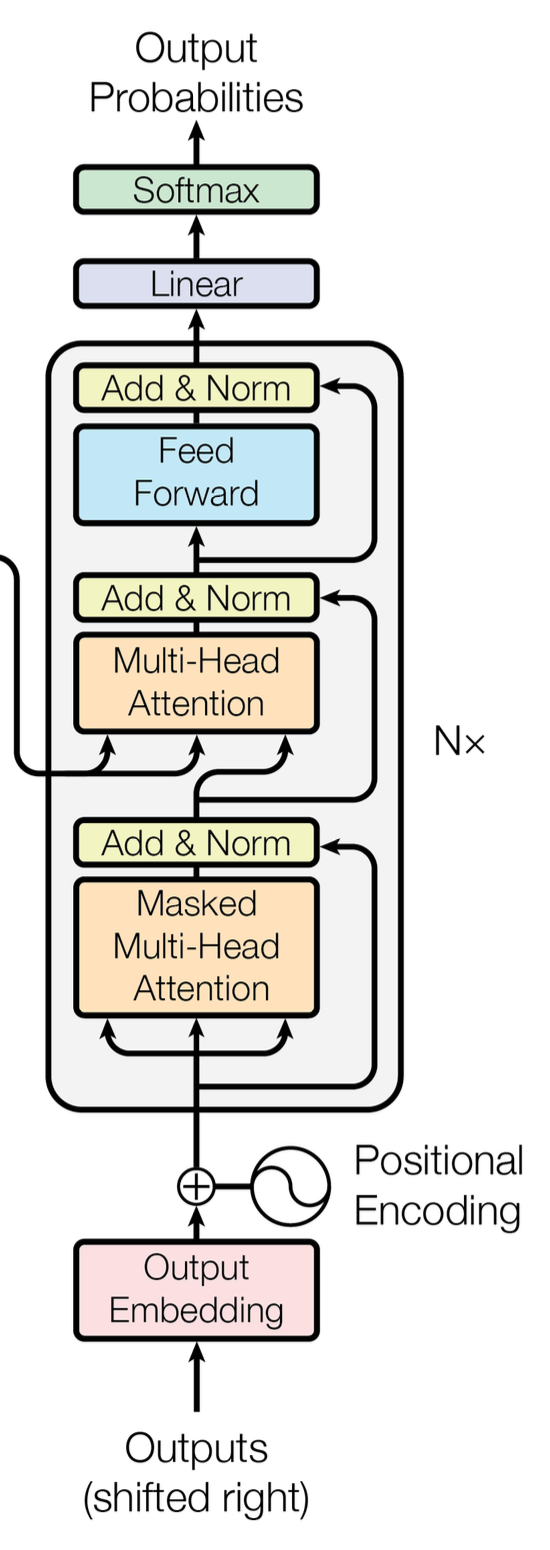

这个 `DecoderBlock` 类是 Transformer 解码器（Decoder）中的一个基本模块，主要用于处理输入的解码序列，同时结合编码器（Encoder）输出的信息。它包含了多头自注意力机制、前馈神经网络和残差连接等部分。

In [7]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: 嵌入向量的维度
           expansion_factor: 前馈网络中的扩展因子
           n_heads: 多头注意力头的数量
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads=n_heads)  # 解码器中的自注意力机制
        self.norm = nn.LayerNorm(embed_dim)  # 归一化层，用于稳定网络训练
        self.dropout = nn.Dropout(0.2)  # dropout，用于防止过拟合
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)  # 解码器中的 transformer 模块

    def forward(self, key, query, x, mask):
        """
        Args:
           key: Key 向量，通常来自编码器的输出
           query: Query 向量，来自解码序列
           x: 输入解码序列
           mask: 遮掩掩码，用于屏蔽未来信息

        Returns:
           out: 解码器块的输出
        """

        # 对解码器输入进行自注意力计算，传入 mask 防止查看未来信息
        attention = self.attention(x, x, x, mask=mask)  # 输出大小为 (batch_size, seq_len, embed_dim)

        # 残差连接，并通过归一化和 dropout
        value = self.dropout(self.norm(attention + x))

        # 将处理后的 `value` 传入 TransformerBlock，与来自编码器的 `key` 和 `query` 进行进一步处理
        out = self.transformer_block(key, query, value)

        return out


这个 `TransformerDecoder` 类是 Transformer 解码器的完整实现，它由词嵌入层、位置编码层、多个解码块（`DecoderBlock`），以及最终的全连接层组成。解码器的主要作用是生成输出序列，例如机器翻译中的目标语言序列。

In [8]:
class TransformerDecoder(nn.Module):
    # 初始化方法定义了解码器的主要组件，包括嵌入层、位置编码层、多个 DecoderBlock 层和一个全连接层。
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerDecoder, self).__init__()
        """  
        Args:
           target_vocab_size: 目标词汇表的大小
           embed_dim: 嵌入向量的维度
           seq_len : 输入序列的长度
           num_layers: 解码器层的数量
           expansion_factor: 前馈网络中的扩展因子
           n_heads: 多头注意力头的数量
        """
        
        # 词嵌入层
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        
        # 位置编码层
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)

        # 多个解码层（DecoderBlock）
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=expansion_factor, n_heads=n_heads) 
                for _ in range(num_layers)
            ]
        )
        
        # 输出层，全连接层将嵌入维度转换为词汇表大小
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        
        # dropout 用于防止过拟合
        self.dropout = nn.Dropout(0.2)

    # 前向传播过程中，输入序列首先经过嵌入层和位置编码层，然后通过多个 DecoderBlock 进行处理，最后通过全连接层输出每个位置上词汇的概率分布。
    def forward(self, x, enc_out, mask):
        """
        Args:
            x: 来自目标序列的输入向量（目标词汇的嵌入）
            enc_out: 来自编码器的输出
            mask: 自注意力机制的掩码，用于防止模型看到未来信息

        Returns:
            out: 解码器的输出向量
        """

        # 词嵌入 + 位置编码
        x = self.word_embedding(x)  # 词嵌入 (batch_size, seq_len, embed_dim) -> (32, 10, 512)
        x = self.position_embedding(x)  # 位置编码 (32, 10, 512)
        x = self.dropout(x)  # 加入 dropout，防止过拟合

        # 多层解码器块
        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask)  # 在每层解码器中，将编码器的输出 `enc_out` 和解码器的 `x` 进行结合

        # 全连接层，生成词汇表大小的输出概率分布
        out = F.softmax(self.fc_out(x), dim=-1)  # (batch_size, seq_len, target_vocab_size)

        return out


## 5.完整架构
最后，我们将组装所有子模块并创建整个 Transformer 架构。

这个 `Transformer` 类实现了一个完整的 Transformer 模型，它由**编码器**（`TransformerEncoder`）和**解码器**（`TransformerDecoder`）组成，用于处理序列到序列的任务，比如机器翻译。模型的前向传播和推理过程都得到了实现。

In [9]:
class Transformer(nn.Module):
    # 在初始化方法中，定义了编码器、解码器以及它们的超参数，如嵌入维度、词汇表大小、序列长度等。
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length, num_layers=2, expansion_factor=4, n_heads=8):
        super(Transformer, self).__init__()
        
        """  
        Args:
           embed_dim: 嵌入向量的维度
           src_vocab_size: 源语言的词汇表大小
           target_vocab_size: 目标语言的词汇表大小
           seq_length: 输入序列的长度
           num_layers: 编码器和解码器的层数
           expansion_factor: 前馈网络中的扩展因子
           n_heads: 多头注意力头的数量
        """
        
        self.target_vocab_size = target_vocab_size

        # 初始化 Transformer 编码器
        self.encoder = TransformerEncoder(
            seq_length, src_vocab_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads
        )
        
        # 初始化 Transformer 解码器
        self.decoder = TransformerDecoder(
            target_vocab_size, embed_dim, seq_length, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads
        )


    # 这是一个用于生成目标序列掩码（`mask`）的函数。解码器在生成序列时不能看到未来的信息，因此需要掩码来屏蔽未来的词。
    def make_trg_mask(self, trg):
        """
        Args:
            trg: 目标序列
        Returns:
            trg_mask: 目标序列的掩码
        """
        batch_size, trg_len = trg.shape
        # 返回一个下三角矩阵，其中上三角部分被屏蔽
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask

    # `decode` 函数用于推理过程中的解码，它逐步生成序列中的下一个词
    def decode(self, src, trg):
        """
        推理过程中逐步生成序列
        Args:
            src: 编码器的输入
            trg: 解码器的输入
        Returns:
            out_labels: 生成的序列标签
        """
        trg_mask = self.make_trg_mask(trg)  # 生成解码器掩码
        enc_out = self.encoder(src)  # 通过编码器处理源序列
        out_labels = []  # 保存生成的输出序列
        batch_size, seq_len = src.shape[0], src.shape[1]
        out = trg  # 目标序列的初始输入

        for i in range(seq_len):
            # 逐步通过解码器
            out = self.decoder(out, enc_out, trg_mask)  # (batch_size, seq_len, vocab_size)

            # 取出最后一个时间步的输出
            out = out[:, -1, :]  # (batch_size, vocab_size)

            # 获取输出的最大概率词汇索引
            out = out.argmax(-1)  # (batch_size,)

            # 保存当前步的预测结果
            out_labels.append(out.item())

            # 将预测出的词添加到输入序列中，继续下一个时间步的预测
            out = torch.unsqueeze(out, axis=0)

        return out_labels  # 返回生成的序列

    # `forward` 函数用于训练阶段，处理完整的源序列和目标序列。
    def forward(self, src, trg):
        """
        Args:
            src: 编码器的输入
            trg: 解码器的输入
        Returns:
            outputs: 解码器的输出，包含每个词汇的概率分布
        """
        trg_mask = self.make_trg_mask(trg)  # 生成目标序列掩码
        enc_out = self.encoder(src)  # 通过编码器处理源序列
        outputs = self.decoder(trg, enc_out, trg_mask)  # 通过解码器处理目标序列

        return outputs  # 返回目标词汇的概率分布


## 6.简单测试一下我们的代码
### 创建模型和准备训练数据
创建了一个 `Transformer` 模型，并准备了源序列 (`src`) 和目标序列 (`target`) 作为输入

In [10]:
# 输入的参数
src_vocab_size = 11
target_vocab_size = 11
num_layers = 6
seq_length= 12

# 训练数据
# 模拟的源序列和目标序列，包含sos和eos tokens
# `src` 和 `target` 序列中都包括特殊的开始符（`sos`，用 0 表示）和结束符（`eos`，用 1 表示）。
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], 
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], 
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

# 打印输入的形状
print(src.shape, target.shape)

# 创建Transformer模型
model = Transformer(embed_dim=512, 
                    src_vocab_size=src_vocab_size, 
                    target_vocab_size=target_vocab_size, 
                    seq_length=seq_length,
                    num_layers=num_layers, 
                    expansion_factor=4, 
                    n_heads=8)

# 打印模型以确认其结构
print(model)

torch.Size([2, 12]) torch.Size([2, 12])
Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(
      (embed): Embedding(11, 512)
    )
    (positional_encoder): PositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=64, out_features=64, bias=False)
          (key_matrix): Linear(in_features=64, out_features=64, bias=False)
          (value_matrix): Linear(in_features=64, out_features=64, bias=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, i

### 训练一次（前向传播）
通过源序列 `src` 和目标序列 `target` 进行一次前向传播的训练。
这个 `out` 是解码器对每个时间步的词汇预测。它的形状通常是 `(batch_size, seq_len, target_vocab_size)`。其中每个时间步都会生成一个词汇表大小的概率分布。

In [11]:
out = model(src, target)
print(out.shape)
print(out)

torch.Size([2, 12, 11])
tensor([[[0.0524, 0.0737, 0.0467, 0.1041, 0.2478, 0.1303, 0.0368, 0.1759,
          0.0364, 0.0413, 0.0544],
         [0.0662, 0.0381, 0.0646, 0.1432, 0.2474, 0.0464, 0.0453, 0.0704,
          0.1182, 0.0600, 0.1003],
         [0.1201, 0.0416, 0.1106, 0.1029, 0.1391, 0.0896, 0.1082, 0.1316,
          0.0807, 0.0326, 0.0432],
         [0.0366, 0.1041, 0.0374, 0.1666, 0.1117, 0.0985, 0.1243, 0.0741,
          0.0925, 0.0340, 0.1202],
         [0.0429, 0.0539, 0.0939, 0.0708, 0.0494, 0.1672, 0.1142, 0.0768,
          0.0980, 0.0984, 0.1344],
         [0.0797, 0.0294, 0.0855, 0.0491, 0.0534, 0.2018, 0.0377, 0.1033,
          0.2145, 0.0629, 0.0827],
         [0.0366, 0.0464, 0.2815, 0.0488, 0.0624, 0.1138, 0.0557, 0.1361,
          0.0700, 0.0197, 0.1289],
         [0.2349, 0.0562, 0.0531, 0.0558, 0.0694, 0.1946, 0.0374, 0.0583,
          0.0755, 0.0692, 0.0955],
         [0.1109, 0.1321, 0.0492, 0.0908, 0.0627, 0.1152, 0.1179, 0.0901,
          0.0816, 0.0860, 0.06

### 推理
在推理过程中，模型会通过编码器处理 `src`，然后在每个时间步上通过解码器逐步生成下一个词。`out` 是模型生成的目标序列，包含生成的词汇索引。

In [12]:
# 创建模型
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size, 
                    target_vocab_size=target_vocab_size, seq_length=seq_length, 
                    num_layers=num_layers, expansion_factor=4, n_heads=8)

# 源序列 src (1 个句子，长度为 12)
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1]])

# 目标序列的初始部分 trg，初始为 <sos> token (0)
trg = torch.tensor([[0]])

# 打印输入的形状
print("Source shape:", src.shape)  # (1, 12)
print("Target shape (initial):", trg.shape)  # (1, 1)

# 调用模型的推理函数进行解码
out = model.decode(src, trg)

# 打印输出结果
print("Generated output:", out)


Source shape: torch.Size([1, 12])
Target shape (initial): torch.Size([1, 1])
Generated output: [8, 2, 8, 10, 5, 0, 10, 6, 6, 6, 6, 5]
